# divide observations into watermasses based on location

In [9]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interpn
import cmocean as cm
import gsw

from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings
warnings.filterwarnings("ignore")

In [2]:
grid = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/grid.nc')
obs = pd.read_csv('/data/rbeutel/obs/PNW_obs_compiled.csv')

In [3]:
# salish sea cuttoff
x = np.linspace(-130,-122,10)
m = -0.83
b = 48.4-(-124.6)*m

ind = np.where(obs['longitude (degrees_east)'] > (obs['latitude (degrees_north)']-b)/m) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

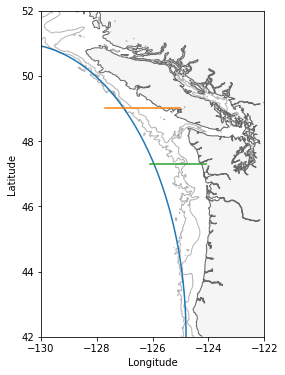

In [4]:
fig, ax = plt.subplots(1,1,figsize=(4, 6))

ax.contourf(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='whitesmoke')
ax.contour(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='dimgray')
ax.contour(grid.lon_rho, grid.lat_rho,grid.h, linewidths=1, levels=[200, 1000], colors='dimgray', alpha=0.5)
# ax.contour(grid.lon_rho, grid.lat_rho,grid.h, linewidths=1, levels=[2000], colors='r')

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_ylim([42,52])
ax.set_xlim([-130,-122])

# offshore cuttoff 
y=np.linspace(42,52,100)
x = np.sqrt((1-((y-42)**2)/(9**2))*(6**2))-130.8
ax.plot(x,y)

#north cuttoff
ax.plot([-127.7,-125],[49,49])

# south cuttoff
ax.plot([-126.1,-124.1],[47.3,47.3])
# south deep s>=33.9
# south shelf s>=32 <33.9
# south fresh s<32

In [5]:
# code for separating observations into groups based on location and depth
def region(lat,lon,salinity,d):
    if  lon > np.sqrt((1-(((lat-42)**2)/(9**2)))*(6**2))-130.8:
        return 1 #offshore
    elif lat > 49:
        return 2 #north
    elif lat < 47.3:
        if salinity >= 33.9:
            return 3 #south
        elif salinity < 32:
            return 4
        else:
            return 5
    else:
        return 6  #domain

regions = ['Offshore', 'North', 'South Deep', 'South Fresh', 'South Shelf']

In [6]:
obs['region'] = [region(obs['latitude (degrees_north)'][i],obs['longitude (degrees_east)'][i],obs['salinity (g kg-1)'][i],obs['depth (m)'][i]) for i in range(len(obs))]

In [7]:
# separate summer and winter
obs['time']=pd.to_datetime(obs.time)
obs['month'] = [obs.time[i].month for i in obs.index]

wob = obs[(obs.month >=11) | (obs.month <=2)]
sob = obs[(obs.month >= 5) & (obs.month <=8)]

In [12]:
# I want to add lines of constant spice
smin, smax = 28.2,36.6
tmin, tmax = 1,19.6
bins = [np.linspace(smin, smax,100),np.linspace(tmin, tmax,100)]
SA, t = np.meshgrid(bins[0],bins[1])
p = np.array([50 for i in range(np.shape(SA)[0]*np.shape(SA)[1])])
p = p.reshape(100,100)

CT = np.zeros(np.shape(p))
rho = np.zeros(np.shape(p))
spice = np.zeros(np.shape(p))

for i in range(np.shape(p)[0]): 
    CT[i,:] = gsw.CT_from_t(SA[i,:],t[i,:],p[i,:])
    rho[i,:] = gsw.rho_alpha_beta(SA[i,:], CT[i,:], p[i,:])[0]
    spice[i,:] = gsw.spiciness0(SA[i,:], CT[i,:])

def fmt(x):
    x-=1000
    s = f"{x:.0f}"
    return rf"{s}"

## South

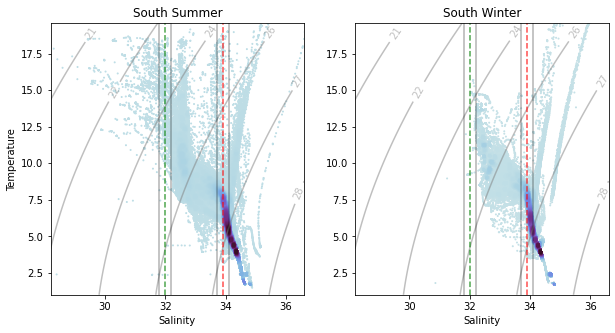

In [15]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

# SUMMER
salt = sob['salinity (g kg-1)'][(sob.region == 3) | (sob.region == 4) | (sob.region ==5)].reset_index(drop=True)
temp = sob['temperature (degC)'][(sob.region == 3) | (sob.region == 4) | (sob.region ==5)].reset_index(drop=True)

bin = [np.linspace(smin,smax,100),np.linspace(tmin,tmax,100)]
data, x_e, y_e = np.histogram2d(salt,temp, bins = bin, density = True )
z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ), data ,np.vstack([salt,temp]).T ,method = "splinef2d", bounds_error = False)
z[np.where(np.isnan(z))] = 0.0

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
salt, temp, z = salt[idx], temp[idx], z[idx]
                    
ax[0].scatter(salt,temp, c=z, cmap=cm.cm.dense,s=1)
title = "South Summer"
ax[0].set_title(title)
ax[0].set_ylabel('Temperature')

# Winter
salt = wob['salinity (g kg-1)'][(wob.region == 3) | (wob.region == 4) | (wob.region ==5)].reset_index(drop=True)
temp = wob['temperature (degC)'][(wob.region == 3) | (wob.region == 4) | (wob.region ==5)].reset_index(drop=True)

smin, smax = 28.2,36.6
tmin, tmax = 1,19.6
bin = [np.linspace(smin,smax,100),np.linspace(tmin,tmax,100)]
data, x_e, y_e = np.histogram2d(salt,temp, bins = bin, density = True )
z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ), data ,np.vstack([salt,temp]).T ,method = "splinef2d", bounds_error = False)
z[np.where(np.isnan(z))] = 0.0

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
salt, temp, z = salt[idx], temp[idx], z[idx]
                    
ax[1].scatter(salt,temp, c=z, cmap=cm.cm.dense,s=1)
title = "South Winter"
ax[1].set_title(title)

for i in range(len(ax)):
    ax[i].set_xlabel('Salinity')
    ax[i].set_ylim([tmin,tmax])
    ax[i].set_xlim([smin,smax])

    # density
    CS=ax[i].contour(SA,t,rho,colors = 'gray', alpha=0.5)
    ax[i].clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)

    # apply boundaries from CIOPS analysis
    # division between water masses
    ax[i].plot([33.9,33.9],[tmin,tmax],'r--', alpha=0.7, label='Deep division')
    ax[i].plot([34.1,34.1],[tmin,tmax],'k', alpha=0.3)
    ax[i].plot([33.7,33.7],[tmin,tmax],'k', alpha=0.3)

    # columbia delineation
    ax[i].plot([32,32],[tmin,tmax],'g--',alpha=0.7,label='Columbia division')
    ax[i].plot([32.2,32.2],[tmin,tmax],'k', alpha=0.3)
    ax[i].plot([31.8,31.8],[tmin,tmax],'k', alpha=0.3)

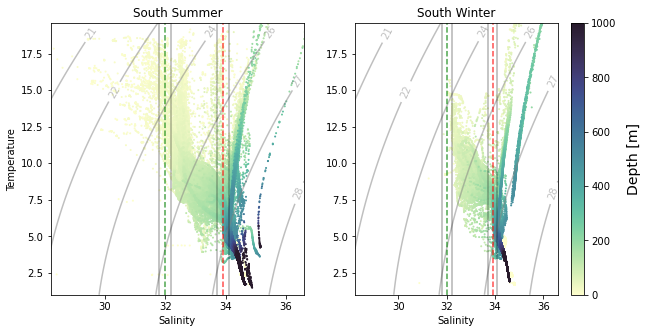

In [18]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

# SUMMER
salt = sob['salinity (g kg-1)'][(sob.region == 3) | (sob.region == 4) | (sob.region ==5)].reset_index(drop=True)
temp = sob['temperature (degC)'][(sob.region == 3) | (sob.region == 4) | (sob.region ==5)].reset_index(drop=True)
z = sob['depth (m)'][(sob.region == 3) | (sob.region == 4) | (sob.region ==5)].reset_index(drop=True)

smin, smax = 28.2,36.6
tmin, tmax = 1,19.6

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
salt, temp, z = salt[idx], temp[idx], z[idx]
                    
ax[0].scatter(salt,temp, c=z, cmap=cm.cm.deep,s=1,vmin=0,vmax=1000)
title = "South Summer"
ax[0].set_title(title)
ax[0].set_ylabel('Temperature')

# Winter
salt = wob['salinity (g kg-1)'][(wob.region == 3) | (wob.region == 4) | (wob.region ==5)].reset_index(drop=True)
temp = wob['temperature (degC)'][(wob.region == 3) | (wob.region == 4) | (wob.region ==5)].reset_index(drop=True)
z = wob['depth (m)'][(wob.region == 3) | (wob.region == 4) | (wob.region ==5)].reset_index(drop=True)

# Sort the points by depth, so that the deepest points are plotted last
idx = z.argsort()
salt, temp, z = salt[idx], temp[idx], z[idx]
                    
sc = ax[1].scatter(salt,temp, c=z, cmap=cm.cm.deep,s=1,vmin=0,vmax=1000)
cb = fig.colorbar(sc, ax=ax[1])
cb.set_label('Depth [m]', labelpad=10, fontsize=14)
title = "South Winter"
ax[1].set_title(title)

for i in range(len(ax)):
    ax[i].set_xlabel('Salinity')
    ax[i].set_ylim([tmin,tmax])
    ax[i].set_xlim([smin,smax])

    # density
    CS=ax[i].contour(SA,t,rho,colors = 'gray', alpha=0.5)
    ax[i].clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)

    # apply boundaries from CIOPS analysis
    # division between water masses
    ax[i].plot([33.9,33.9],[tmin,tmax],'r--', alpha=0.7, label='Deep division')
    ax[i].plot([34.1,34.1],[tmin,tmax],'k', alpha=0.3)
    ax[i].plot([33.7,33.7],[tmin,tmax],'k', alpha=0.3)

    # columbia delineation
    ax[i].plot([32,32],[tmin,tmax],'g--',alpha=0.7,label='Columbia division')
    ax[i].plot([32.2,32.2],[tmin,tmax],'k', alpha=0.3)
    ax[i].plot([31.8,31.8],[tmin,tmax],'k', alpha=0.3)